# Titanic dataset analysis

The aim of this project is to analyse the [Kaggle Titanic dataset](https://www.kaggle.com/c/titanic/data "Kaggle training dataset"), which includes the following steps: 

1. Defining the list of questions to be answered with data analysis.
2. Data wrangling (including its cleansing and adding additional fields) to allow for more convenient consumption of the data and making analysis possible.
3. Data exploration and effective communication of the exploratory steps.
4. Summarising conclusions.

### 1. Defining the list of questions to be answered with data analysis

There are many ways to explore the data and dozens of potential questions to ask. After some brainstorming, I have come up with the following: 
1. What was the distribution of age across the passengers? Was it different between men and women? test change 
2. What was the distribution of ticket fares? What were the average and the most expensive tickets? How much would this average and the most expensive tickets worth now?
3. How many passengers embarked in different ports? Can we detect the port where the richest passengers embarked? How much would the median price for this subset of passengers worth now?
4. How many passengers by gender were there on the ship? What was the survival rate for men, women and children? Was sex correlated to the survival rate? 
5. What was the distribution of passengers among different classes? What was the survival rate among different ticket classes? Was ticket class correlated to the survival rate? 

### 2. Data wrangling

Firstly, let's import the data, as well as the libraries which will be required further. Then we will call the pandas describe function to see whether any values may require cleansing and to examine whether any modifications are required. Also, I do not really like acronims in the 'Embarked' field - we will change them to the real city names. 

In [359]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

titanic_df = pd.read_csv('titanic-data.csv')

# Function to convert acronyms to the city names 
def convert_city(record):
    if record == "S": 
        return "Southampton"
    if record == "C": 
        return "Cherbourg" 
    if record == "Q": 
        return "Queenstown" 

# Run the finction
titanic_df['Embarked'] = titanic_df['Embarked'].apply(convert_city)
# Show the dataset info
titanic_df.describe()

Populating the interactive namespace from numpy and matplotlib


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The mininum age of 0.42 seems suspicious - did they allow infants to embark back then? According to a [Theguardian article](https://www.theguardian.com/world/2009/jun/01/last-titanic-survivor-dies "The guardian article") about one of Titanic survivors, "as a two-month-old baby, Dean was the youngest passenger on board", and 2 months is 0.17 years - so, the suspicion is groundless. 

'Fare' field has zero (0.0) values, which means either that somebody embarked for free or that this data is missing. Let's see how many of records with zero fares are present in the dataset. 

In [360]:
# Getting a subset of rows of the dataframe where 'Fare' field equals zero and counting the number of elements. 
# Other fields may be empty so we count by the same 'Fare' field:  

zerofare = titanic_df[(titanic_df['Fare'] == 0.0)]['Fare'].count()
print 'The number of zero-fare passengers: {}'.format(zerofare)

The number of zero-fare passengers: 15


To understand whether this has a significant impact on the data quality, we need to check the overall number of records. Let's run the info() function on our dataframe. This will also allow us examine whether some values are not filled in (have NaN as a value). 

In [361]:
titanic_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

The total number of records is 891, so we can see that values are not complete for the fields 'Age', 'Cabin', and 'Embarked' (<small>why use a calculator when we could code, right?</small>): 

In [362]:
# Get the number of non-filled (NaN) records using pandas isnull function 
# And calculating the number of true values in the resulting numpy array

total_records = titanic_df['PassengerId'].count()

no_age = numpy.sum(pd.isnull(titanic_df['Age']))
no_cabin = numpy.sum(pd.isnull(titanic_df['Cabin']))
no_embarked = numpy.sum(pd.isnull(titanic_df['Embarked']))

print '\"Age\" not entered for {} records ({:.2%})'.format(no_age, (float(no_age)/total_records))
print '\"Cabin\" not entered for {} records ({:.2%})'.format(no_cabin, (float(no_cabin)/total_records))
print '\"Embarked\" not entered for {} records ({:.2%})'.format(no_embarked, (float(no_embarked)/total_records))

"Age" not entered for 177 records (19.87%)
"Cabin" not entered for 687 records (77.10%)
"Embarked" not entered for 2 records (0.22%)


Considering the results, we should: 
* not be analysing our dataset by cabin as a lot of values are missing
* acknowledge that our age data is incomplete

We should also note that several of our questions requires data on whether a passenger is a child or not, and this is not explicitly included in the dataset. Let's investigate what 'a child' means in terms of age according to 1900s and write a function to enrich our dataset with new values. An online resource 20thcenturylondon.org.uk [is indicating](http://www.20thcenturylondon.org.uk/children "20thcenturylondon.org.uk/children") the following: 
> The 1908 Children's Charter enshrined childhood to the age of 14

Therefore, let's create a function to classify passengers using this threshold and apply it to the dataframe. As we will need to analyse the data from the view men / women / children, it would be handy to create a new field and populate it with one of these three values. 

Also, remembering that age is not filled for some values, we should think about a way to deal with this issue. I dediced to fill missing values using a proxy - median values of sex and ticket class. The same will be done for the 'Embarked' field, for which just 2 values are NaNs. 

In [363]:
# Suggestion for future code - being mindful of pandas.cut function even if not applicable in this specific case: 
# E.g. titanic_df['SStatus'] = pandas.cut(titanic_df['Age'], bins=[0,14,40,90], labels=['Childs','Adults','Seniors'])

from scipy.stats.mstats import mode

# Function to check the age and classify as a child or an adult (male / female) 
def is_child(record):
    age = record['Age']
    sex = record['Sex']
    if age < 14:
        return 'child'
    else:
        return sex
                       
"""
Uncomment to check how NaNs would be fixed with proxies
print "Age median values by Sex, PClass, and Embarked fields:"
print titanic_df.groupby(['Sex','Pclass','Embarked'], as_index=False).median().loc[:, ['Sex','Pclass', 'Embarked', 'Age']]

print "Embarked median values by Sex and PClass fields:" 
print titanic_df.groupby(['Sex','Pclass'], as_index=False).max().loc[:, ['Sex','Pclass', 'Embarked']]

print "First 5 passengers in the dataset for which age is missing:"
print titanic_df.loc[titanic_df['Age'].isnull(),['Age','Sex','Pclass']].head(5)
"""

# Apply transformation: 'Age' missing values are filled using information on Sex, Pclass, and Embarked fields:
titanic_df.loc[:, 'Age'] = titanic_df.groupby(['Sex','Pclass','Embarked']).transform(lambda x: x.fillna(x.median()))

# Apply transformation: 'Embarked' missing values are filled using information on the most frequent port by Sex / Pclass fields:
titanic_df.loc[:, 'Embarked'] = titanic_df.groupby(['Sex','Pclass']).transform(lambda x: x.fillna(x.value_counts().index[0]))

# As the function returns a series, we need to apply it to the original dataframe
# Axis = 1 as the function should be applied to columns

titanic_df['SStatus'] = titanic_df[['Age', 'Sex']].apply(is_child, axis=1)
titanic_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SStatus
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,Cherbourg,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,Southampton,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,Southampton,male


All right, now we are ready to move to the next step (data exploration and communication).

### 3. Data exploration and communication 

Now let's revisit the questions which we defined in the beginning.

**1. What was the distribution of age across the passengers? Was it different between men and women?**

Minding that the maximum age is 80 (as we saw previously), we will create a histogram with 80 bins and show the mean. 

(0, 80)

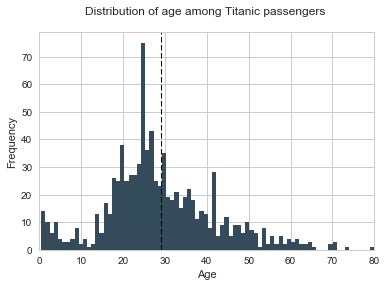

In [364]:
# Set a palette and a style 
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Blues_d")) 

titanic_df['Age'].hist(bins = 80)
plt.axvline(titanic_df['Age'].mean(), color='black', linestyle='dashed', linewidth=1)
plt.title("Distribution of age among Titanic passengers \n")
plt.ylabel("Frequency")
plt.xlabel("Age")
# Limits the x axis
pylab.xlim(xmin=0, xmax=80)

To grasp more details and see the difference between men and women, it would be handy to use sns boxplots (showing medians, InterQuartile Ranges, minimums / maximums, and outliers):  

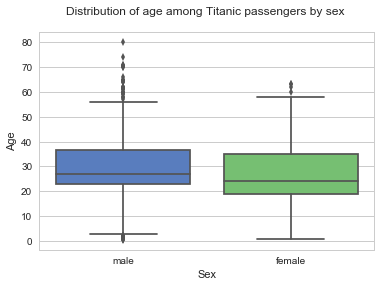

In [365]:
sns.boxplot(x="Sex", y="Age", data=titanic_df, palette="muted")
plt.title("Distribution of age among Titanic passengers by sex \n")

**Conclusion 1**: The distribution of the age of passengers is positively skewed, and the majority of the passengers were between the age of 20 and 36. For men's age, median and maximum are higher than for women - therefore, we can say that men on the ship were generally older than women. 

**2. What was the distribution of ticket fares? What were the average and the most expensive tickets? How much would this average and the most expensive tickets worth now?**

This time let's visualise the data with sns distribution plot.  

The description of data on fares (ticket prices) in the dataset:


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

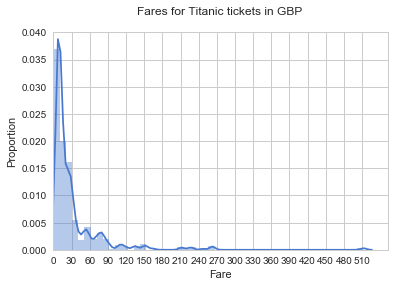

In [366]:
# Set palette and plot the data
sns.set_palette(sns.color_palette("muted")) 
sns.distplot(titanic_df['Fare'])
plt.title("Fares for Titanic tickets in GBP \n")
plt.ylabel('Proportion')
# Put some more ticks 
plt.xticks(np.arange(titanic_df['Fare'].min(), titanic_df['Fare'].max()+1, 30))

# Minor axis visualisation corrections so the graph looks better
pylab.xlim(xmin=0)
pylab.ylim(ymax=0.040)

# Describe the ticket fare array 
print 'The description of data on fares (ticket prices) in the dataset:'
titanic_df['Fare'].describe()

The mean (average) price for a ticket was 32.2 GBP, and the distribution of ticket prices is positively skewed. The majority of tickets cost less than 90 GBP. 

To recalculate historical values into the current prices (or vice versa), we will need to get the convertion rate somewhere and write an appropriate function. *Note that Titanic left the maiden port in 1912 and crashed the same year*. By googling "historical UK inflation rates", one could find a number of ready-to-use calculators and tables - for example, [here](http://inflation.stephenmorley.org/). I have copied the contents of the table on this website and saved it in a csv file. Let's import it and take a look at the contents once again: 

In [367]:
# Read the file and set year as index
infl_df = pd.read_csv('UK_inflation.csv', index_col='Year')
infl_df.head()

,Inflation,Multiplier
Year,,
2017,-,1.00
2016,1.80%,1.02
2015,1.00%,1.03
2014,2.40%,1.05
2013,3.00%,1.08


Now, what would be the appropriate method to calculate the historical values? Considering the inflation data format in the file, we can use multipliers to simplify the task and avoid using loops: 

\begin{align}
Value_{historical} = \frac{Value_{current}Multiplier_{historical}}{Multiplier_{current}}
\end{align}

In [368]:
# Delete the inflation column
infl_df = infl_df.drop("Inflation", axis=1)

# Define a function and use it
def curr_value(hist_y, curr_y, amount):
    return round((amount*infl_df.loc[hist_y])/infl_df.loc[curr_y], 2)

# Maximum ticket price as of now
print 'Maximum price for titanic tickets as of now: {} GBP'.format(curr_value(1912, 2017, titanic_df['Fare'].max()))
# Mean ticket price as of now
print 'Mean price for titanic tickets as of now: {} GBP'.format(curr_value(1912, 2017, titanic_df['Fare'].mean()))

Maximum price for titanic tickets as of now: 55331.55 GBP
Mean price for titanic tickets as of now: 3478.05 GBP


**Conclusion 2**: The mean (average) price for a ticket was 32.2 GBP, and the distribution of ticket prices is positively skewed. The maximum price for a ticket was 512.33 GBP. The current equivalent of these prices is 3478.05 GBP for the mean and 55331.55 GBP (wow!) for the most expensive ticket. 

**3. How many passengers embarked in different ports? Can we detect the port where the richest passengers embarked? How much would the median price for this subset of passengers worth now?**

Let's start with looking at a plot showing the number of passengers by port:

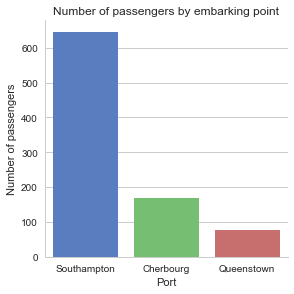

In [369]:
# As seaborn factorplot does not have parameters for titles and since will be drawing several factorplots - define a function:
def factorplot_draw(xparam, data, kind, title, ylabel, xlabel, palette='muted', yparam=None, order=None, hue=None): 
    sns.set_palette(palette)
    sns.factorplot(x=xparam, y=yparam, hue=hue, data=data, kind=kind)
    plt.title(title)
    plt.ylabel(ylabel) 
    plt.xlabel(xlabel)  
    plt.show()

# Plotting passengers by port 
factorplot_draw('Embarked', titanic_df, 'count', 'Number of passengers by embarking point','Number of passengers','Port')

Let's check the route map and compare it with the results: 

<img src="images/map.jpg" align = "left">

The results are in line with my expectations - the majority of passengers were from the United Kingdom. 

Rephrasing the second question, we actually would like to know whether the median ticket price for the passengers embarked at one of the ports is higher than of the others, and whether it is significantly different from the population of titanic passengers. We can investigate this, but this would certainly not mean that these passengers were the richest since the *ticket price is not an appropriate operational definition for wealth*, and we *do not have data to conclude on one's wealth in general*. 

So, let's see what was the distribution of fares between embarking docks.

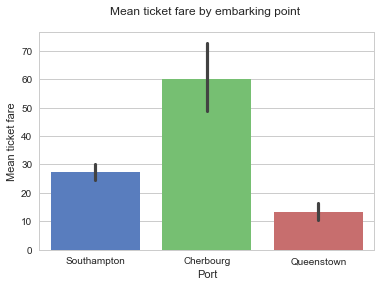

In [370]:
# Plotting ticket fares 
sns.barplot(x="Embarked", y="Fare", data=titanic_df)
plt.title("Mean ticket fare by embarking point \n")
plt.ylabel('Mean ticket fare') 
plt.xlabel('Port')

Cherbourg seems to be leading - indeed, I would assume that European upper crust embarked in France (Cherbourg). However, we need to state a null hypothesis and test it properly before making a conclusion. We will be using one-tail test as we are looking at one direction only. 

\begin{align}
H_{0}: \mu_{Cherbourg} = \mu_{I} \\
H_{1}: \mu_{Cherbourg} > \mu_{I}
\end{align}

We will run [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test "Wiki article") to test the hypothesis - for this, it would be handy to use scipy.stats function called ttest_ind.  

In [371]:
#  Import the ttest_ind funtcion
from scipy.stats import ttest_ind

# A sample for Cherbourg passengers only 
sample = titanic_df[(titanic_df.Embarked == "Cherbourg")]
sample_size = sample['PassengerId'].count()

# Use our function to indicate the sample mean in today's prices 
print 'Mean ticket price for Cherbourg passengers: {} GBP, which is {} in {}\n'.format(
    round(sample['Fare'].mean(),2), curr_value(1912, 2017, sample['Fare'].mean()), 2017)

# T-test
print "Hypothesis testing:"
print "Sample size: {}, df  = {} \n".format(sample_size, sample_size-1)
ttest_ind(sample['Fare'], titanic_df['Fare'])

Mean ticket price for Cherbourg passengers: 59.95 GBP, which is 6475.05 in 2017

Hypothesis testing:
Sample size: 168, df  = 167 



Ttest_indResult(statistic=5.8397069456355295, pvalue=6.9534792765880168e-09)

As we can see, the p-value is much less than 0.05 - therefore, the results are statistically significant with α = 0.05 and we should reject the null. 

**Conclusion 3:** The passengers embarked at Cherbourg purchased more expensive tickets than all the passengers in average. However, we cannot conclude whether they are rich or not as we do not have enough data for this. 

**4. How many passengers by gender were there on the ship? What was the survival rate for men, women and children? Was sex correlated to the survival rate? **

Let's start with checking the distribution of sex among passengers: 

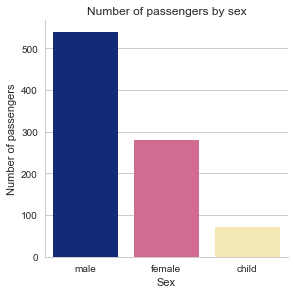

In [372]:
# Let's set the palette - blue for men, pink for women, yellow for children 
palette_by_sex = ["#002388", "#e25a8d", "#ffeeab"]

# Plotting sex distribution
factorplot_draw('SStatus', titanic_df, 'count', 'Number of passengers by sex','Number of passengers','Sex', palette_by_sex)

Looking at the results, we can see that the majority of passengers were men. Indeed: 

In [373]:
# Checking the exact numbers by sex
print "Number of passengers by the field {}".format((titanic_df.groupby('SStatus'))['PassengerId'].count())

Number of passengers by the field SStatus
child      71
female    280
male      540
Name: PassengerId, dtype: int64


Now let's calculate simple survival statistics for men / women / children, and plot a graph.

Survivors - men, women and children (%) 
 SStatus
child     12.280702
female    61.988304
male      25.730994
Name: Survived, dtype: float64


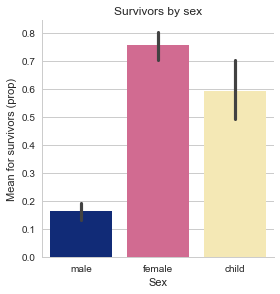

In [374]:
# Calculating the total number of survivors and % of survivors by the passenger type
titanic_df_survived = titanic_df[(titanic_df.Survived == 1)]
total_survived = titanic_df_survived['PassengerId'].count()
survived_percentage = ((titanic_df_survived.groupby('SStatus').count())['Survived']/total_survived)*100

print "Survivors - men, women and children (%) \n {}".format(survived_percentage)

# Plotting 
factorplot_draw('SStatus', titanic_df, 'bar', 'Survivors by sex','Mean for survivors (prop)','Sex', palette_by_sex, 'Survived')

The results are in line with what I expected - the principle 'women and children first' is visually compelling. Still, let's use a proper method to derive the statistical significance of relationship between the variables. We can run a [Chi-Square Test](https://en.wikipedia.org/wiki/Chi-squared_test "Wiki article") to see what is going on here. 

God bless the creators of scipy library - there is already a function for that! However, some additional effort is required to build the crosstable sums (contingency table) of each category-relationship, which should look like this: 

| Survived | child | male | female |
|----------|-------|------|--------|
| 0        | N1    | N2   | N3     |
| 1        | N4    | N5   | N6     |

In [375]:
#  Import the chi2_contingency function
from scipy.stats import chi2_contingency

# build the crosstable sums (contingency table) of each category-relationship
def chi2_df(df, var1, var2):
    sizes = df.groupby([var1, var2]).size()
    # Unstacking moves the inner row indices to the columns
    # This is necessary to pass a proper contingency table to the chi2_contingency function
    ctsum = sizes.unstack(var1)
    # Print the contingency table for information
    print "Contingency table \n", ctsum
    # Remove any NAs to make the function universal
    return(chi2_contingency(ctsum.fillna(0)))

chi2_df(titanic_df, 'SStatus', 'Survived')

Contingency table 
SStatus   child  female  male
Survived                     
0            29      68   452
1            42     212    88


(289.32556061129503,
 1.4919448734025728e-63,
 2L,
 array([[  43.74747475,  172.52525253,  332.72727273],
        [  27.25252525,  107.47474747,  207.27272727]]))

As per the [chi2_contingency documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html), the second returned value is the p-value of the test. The results should be interpreted in the following way: 
* P = 0: both categorical variable are dependent
* P = 1: both variables are independent
* P < 0.05: the relationship between the variables is significant at 95% confidence

As P is much less than 0.05, we can state that gender and survivability are dependant of each other.  

**Conclusion 4:** Gender and survivability are dependent (the results are statistically significant with α = 0.05). The survival rate of women and children during the Titanic crash was higher than the survival rate of men. 

**5. What was the distribution of passengers among different classes? What was the survival rate among different ticket classes? Was ticket class correlated to the survival rate?**

Let's start with plotting the distribution of passengers among ticket classes: 

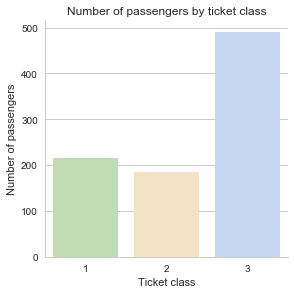

Number of passengers by the field Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64


In [382]:
# Creating a new palette
palette_class = ["#bde3ae", "#f9e6be", "#bed4f9"]

# Plotting sex distribution
factorplot_draw('Pclass', titanic_df, 'count', 'Number of passengers by ticket class',
                'Number of passengers','Ticket class', palette_class)

# Numbers
print "Number of passengers by the field {}".format((titanic_df.groupby('Pclass'))['PassengerId'].count())

We can see that the difference between the 3rd and 1st / 2nd classes is significant, but the quantity of passengers in the first and second class does not differ dramatically. Is it because the price was almost the same? Let's see: 

(-25.616460000000004, 180)

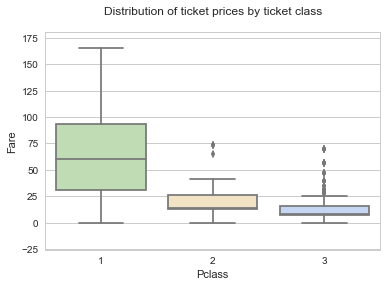

In [377]:
# Boxplot for ticket prices
sns.boxplot(x="Pclass", y="Fare", data=titanic_df)
plt.title("Distribution of ticket prices by ticket class\n")
# Minor axis visualisation corrections so the graph looks better
pylab.ylim(ymax=180)

Apparently, the differences in prices were quite significant. The distribution of passengers among ticket classes is a little bit unexpected, but data is data. 

Let's move to the second question now. While the dependence between sex and survivability is really intuitive, it is hard to guess whether the dependence is in place for the ticket class. Let's take a look at a few graphs: 

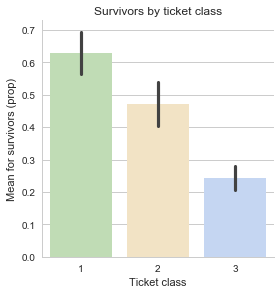

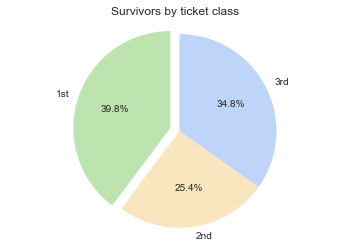

In [378]:
# Plotting a factorplot - proportion of survivors among various classes
factorplot_draw('Pclass', titanic_df, 'bar', 'Survivors by ticket class','Mean for survivors (prop)',
                'Ticket class', palette_class, 'Survived')

# Plotting a pie - ticket classes split between all the survivors 
survived_by_class = titanic_df_survived.groupby('Pclass')
z = survived_by_class.sum()['Survived']/total_survived
labels = '1st', '2nd', '3rd' 
explode = (0.1, 0, 0)  # explode the 1st slice
plt.pie(z, explode=explode, labels=labels, colors=palette_class, autopct='%1.1f%%', startangle=90)
plt.axis('equal') # making the pie chart flat
plt.title("Survivors by ticket class")

The results above represent two different angles: 
* Mean for the field 'survived' (proportion of survived) in the subsets for different ticket classes
* Distribution of ticket classes among all the survivors

From the visuals, it looks that 1st class passengers survived better, but was this because of the ticket class? Looking at the visuals, the correlation is not that clear for the 2nd and 3rd class. Let's run a proper Chi-Square Test for the variables 'Pclass' and 'Survived': 

In [379]:
chi2_df(titanic_df, 'Pclass', 'Survived')

Contingency table 
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


(102.88898875696056,
 4.5492517112987927e-23,
 2L,
 array([[ 133.09090909,  113.37373737,  302.53535354],
        [  82.90909091,   70.62626263,  188.46464646]]))

The p-value is almost zero again - therefore, ticket class and survival are dependent. All right, but now I am thinking - could this be because the proportion of women and children was actually higher in the first class? Let's see: 

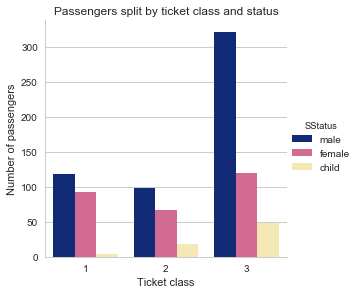

In [380]:
# Plotting split on ticket classes
factorplot_draw('Pclass', titanic_df, 'count', 'Passengers split by ticket class and status', 
                'Number of passengers', 'Ticket class', palette_by_sex, None, None, 'SStatus')

Now let's draw a similar plot for survivors only and view by sex and ticket class: 

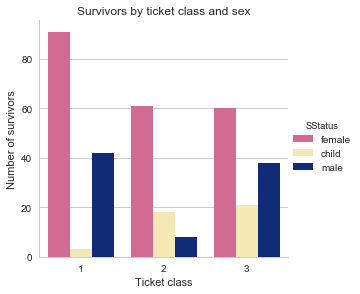

In [381]:
# Fix the palette
palette_by_sex_v2 = ["#e25a8d", "#ffeeab", "#002388"]

# Plot
factorplot_draw('Pclass', titanic_df_survived, 'count', 'Survivors by ticket class and sex', 
                'Number of survivors', 'Ticket class', palette_by_sex_v2, None, None, 'SStatus')

Looking specifically at the number of women and children in the first and the third class (total vs survivors), we can witness that the ticket class really had made a difference. Indeed, the total number of women in the third class was higher than in the first class, but it is vice versa for survivors. The same is valid for children. Seems that we should not have questioned the reliability of Chi-Square Test, but it is always good to check for lurking variables and false assumptions. 

**Conclusion 5:** Ticket class and survivability are dependent (the results are statistically significant with α = 0.05). The survival rate of the first class passengers during the Titanic crash was higher than the survival rate of the second-class passengers. Likewise, the survival rate for the second class was higher than the rate for the third. 

### 4. Summarising conclusions

**1. Age and sex distribution**: 

In the original dataset, age for not specified for 177 (19,87%) records. Missing values were filled using median age by sex, ticket class and port (embarked). This assumption, however, may be incorrect. 

Visualisations have shown that the distribution of the age of passengers is positively skewed, and the majority of the passengers were between the age of 20 and 36. For men's age, median and maximum are higher than for women - therefore, we can say that men on the ship were generally older than women.

**2. Ticket prices**: 

We note that 15 of 891 (1.68%) records had zero fare (ticket price) which could mean that somebody embarked for free or that this data is missing. Zero values were left unchanged as their volume is low and as there could indeed be some free tickets. 

As shown above, the mean (average) price for a ticket was 32.2 GBP, and the distribution of ticket prices is positively skewed. The maximum price for a ticket was 512.33 GBP. The current equivalent of these prices is 3478.05 GBP for the mean and 55331.55 GBP for the most expensive ticket. This equivalent was calculated using inflation data taken from [inflation.stephenmorley.org](http://inflation.stephenmorley.org/). 

**3. Passengers by port and relevant ticket prices**:

In the original dataset, embarked port for not specified for 2 records, which is less than 0.3%. Missing values were filled by analysing the most frequent embarked port by sex and ticket class. This assumption may be incorrect – however, there are only 2 records and even incorrect values would not have a significant impact on our analysis. 

Visualisations have shown that the majority of passengers embarked in Southampton, less in Cherbourg, and the least in Queenstown. 

The passengers embarked at Cherbourg purchased more expensive tickets than all the passengers in average (the results are statistically significant with α = 0.05). However, we cannot conclude whether they are rich or not as we do not have enough data for this.


**4. Gender and survivability**: 

The original dataset includes the ‘Sex’ field, but an additional field ‘SStatus’ was created and filled to differentiate between men / women and children. Passengers whose age was below 14 were considered as children as suggested [by the following article](http://www.20thcenturylondon.org.uk/children "20thcenturylondon.org.uk/children"). We note that data limitations on age, specified in the first conclusion, apply. 

As shown on visualisations and according to values count, the majority of the passengers on the ship were men (540 passengers). There were less women (280) and even less children (71). 

Graphs have demonstrated that women and children survived better than men, and the results were tested to prove the significance at 95% confidence. As the result, gender and survivability are dependent (the results are statistically significant with α = 0.05). The survival rate of women and children during the Titanic crash was higher than the survival rate of men.


**5. Ticket class and survivability**: 

As per visualisations and value counts, the majority of passengers bought third-class tickets (491 passengers). First class was slightly more popular than the second (216 vs 184). Generally, first class were more expensive than the second, and the second was more expensive than the third. However, there were some outliers in the second and third class which were as expensive as the first class tickets. 

Ticket class and survivability are dependent (the results are statistically significant with α = 0.05). The survival rate of the first class passengers during the Titanic crash was higher than the survival rate of the second-class passengers. Likewise, the survival rate for the second class was higher than the rate for the third, as demonstrated on visualisations and as confirmed by statistical testing above. 
 
